In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from tensorflow.keras.models import Model
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import SpeechGenerator
import librosa
#from keras import losses
import python_speech_features as sf

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise1

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


In [2]:
# Root folder of the dataset
dataset_dir = "Dataset/"

In [3]:
# File containing the path that identify the test and validation set
testWAVs = pd.read_csv(dataset_dir + 'testing_list.txt', sep=" ", header = None)[0].tolist()
valWAVs  = pd.read_csv(dataset_dir + 'validation_list.txt', sep=" ", header = None)[0].tolist()

In [4]:
# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':21, 'bed':22, 'bird':23, 'cat':24, 'dog':25, 'follow':26, 
              'forward':27, 'happy':28, 'house':29, 'learn':30, 'marvin':31, 'sheila':32, 'tree':33, 'visual':34, 'wow':0,
              '_background_noise_':0 }
nCategs = 35

In [5]:
# Load all the file in dataset
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    for f in files:
        #if (f.endswith('.wav')):
        if (root != dataset_dir + "_background_noise_") and (f.endswith('.wav')):
            path = root + "/" + f
            #print(path)
            path = path[len(dataset_dir):]
            #print(path)
            allWAVs.append(path)

# Remove from the training set the elements present in test and validation
trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

In [6]:
# Size of sets
print("Train set length: " + str(len(trainWAVs)))
print("Validation set length: " + str(len(valWAVs)))
print("Test set length: " + str(len(testWAVs)))

Train set length: 84843
Validation set length: 9981
Test set length: 11005


In [7]:
# Function to extract the category from the path to the file
def _getFileCategory(file, catDict):
    # Receives a file with name <cat>/<filename> and returns an integer that is catDict[cat]
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ, 0)

In [8]:
# Get categories of each set
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

# And test the size of the labels set
print("Train-Labels set length: " + str(len(trainWAVlabels)))
print("Validation-Labels set length: " + str(len(valWAVlabels)))
print("Test-Labels set length: " + str(len(testWAVlabels)))

Train-Labels set length: 84843
Validation-Labels set length: 9981
Test-Labels set length: 11005


In [9]:
# Transoform the train dataset in numpy array and load them 
train = np.array(trainWAVs, dtype = object)
trainLabels = np.array(trainWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the train set:")
for i in range(len(trainWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(trainWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + trainWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + trainWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + trainWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    train[i] = trainWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(trainWAVs)))

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843


In [10]:
# Do the same thing for the validation and the test set
val = np.array(valWAVs, dtype = object)
valLabels = np.array(valWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the validation set:")
for i in range(len(valWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(valWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + valWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + valWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + valWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    val[i] = valWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(valWAVs)))

test = np.array(testWAVs, dtype = object)

print("Loading of the test set:")
for i in range(len(testWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(testWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + testWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + testWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + testWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    test[i] = testWAVs[i] + '.npy' 
    
print(str(i+1) + '/' + str(len(testWAVs)))

Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


In [11]:
#test on the length
print(str(len(trainWAVs)) + " = " + str(len(train)))
print(str(len(valWAVs)) + " = " + str(len(val)))
print(str(len(testWAVs)) + " = " + str(len(test)))

#test on labels 
for i in range(0, 1):
    print("file: " + train[i] + " - label: " + str(trainLabels[i]))
    print("file: " + trainWAVs[i] + " - label: " + str(trainLabels[i]))

84843 = 84843
9981 = 9981
11005 = 11005
file: six/f0522ff4_nohash_3.wav.npy - label: 18
file: six/f0522ff4_nohash_3.wav - label: 18


Text(0.5, 1.0, 'WAV signal')

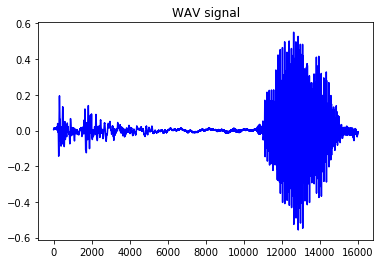

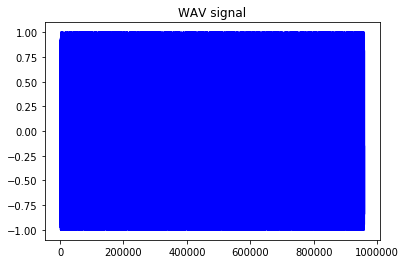

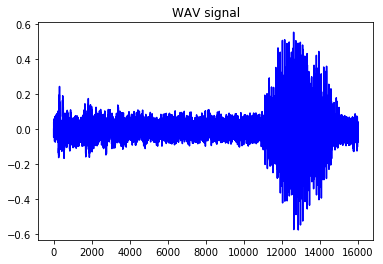

In [12]:
# Function to load numpy array
def load_data(file_name, data_dir):
    # Load the wav signal from the .npy file
    data = np.load(data_dir + file_name)
    return data

# Plot a wav
file_name = train[124]
data = load_data(file_name, dataset_dir)
plt.figure()
plt.plot(data, color='b')
plt.title('WAV signal')

noise = load_data('_background_noise_/white_noise.wav.npy', dataset_dir)
plt.figure()
plt.plot(noise, color='b')
plt.title('WAV signal')

data = addNoise1(data, noise, intensity = 0.1)
plt.figure()
plt.plot(data, color='b')
plt.title('WAV signal')

(100, 80)
(100, 80)


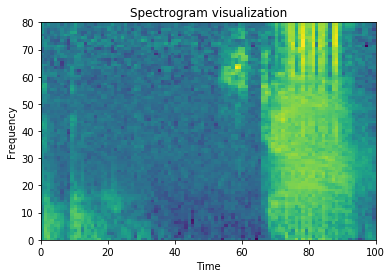

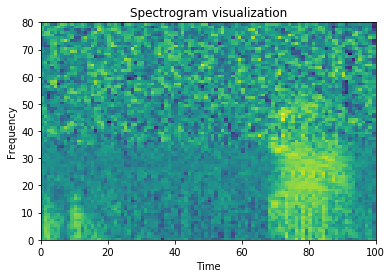

File: stop/99e6cab8_nohash_0.wav.npy - Label: 10


In [14]:
# Function to preprocess the data 
def load_and_preprocess_data(file_name, data_dir, noisy = False):
    # Required by tensorflow (strings are passed as bytes)
    if type(file_name) is bytes:
        file_name = file_name.decode()
        data_dir = data_dir.decode()

    # Load data
    data = np.zeros((16000,))
    d = load_data(file_name, data_dir)
    data[:d.shape[0]] = d
    if noisy:
        noise = load_data('_background_noise_/white_noise.wav.npy', dataset_dir)
        data = addNoise1(data, noise, intensity = 0.1) 
    #feats = computeFeatures1(data, 16000)
    # Normalize
    #feats -= np.mean(feats, axis=0)
    #mean = np.mean(feats, axis = 0)
    #stv = np.std(feats, axis = 0)
    #diff = np.subtract(feats, mean)
    #feats = np.divide(diff, stv + 1e-8)
    #feats = np.divide(feats, np.max(feats))
    #diff1 = np.subtract(feats, np.amin(feats, axis=0))
    #print(np.amin(feats, axis=0))
    #print(np.amax(feats, axis=0))
    #diff2 = np.subtract(np.amax(feats, axis=0), np.amin(feats, axis=0))
    #feats = np.divide(diff1, diff2+1e-6)
    y3 = sf.base.logfbank(data, samplerate = 16000, winlen = 0.016, nfilt=80, nfft = 1024, lowfreq = 40, highfreq = 8000, preemph = 0.95)
    #y3 = np.transpose(y3)    
    mean = np.mean(y3, axis=0)
    #print(mean.shape)
    stv = np.std(y3, axis=0)
    #print(stv.shape)
    diff = np.subtract(y3, mean)
    #print(diff.shape)
    y3 = np.divide(diff, stv + 1e-8)

    return y3.astype(np.float32)

# example:
index = 124
feats = load_and_preprocess_data(train[index], dataset_dir, False)
noise = load_and_preprocess_data(train[index], dataset_dir, True)
print(feats.shape)
print(noise.shape)
feats = np.transpose(feats)
noise = np.transpose(noise)
plt.figure()
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.figure()
plt.pcolormesh(noise)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))

In [15]:
def create_dataset(data_dir, file_names, batch_size = 32, shuffle = True, cache_file = None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name: (tf.py_func(load_and_preprocess_data, [file_name, data_dir, True], tf.float32), 
                                 tf.py_func(load_and_preprocess_data, [file_name, data_dir, False], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls = os.cpu_count())
    
    # Map the add noise function 
    #py_func2 = lambda original: (tf.py_func(addNoise1, [original, noise, 0, False, intensity], tf.float32), original)
    #dataset = dataset.map(py_func2, num_parallel_calls = os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely (capire bene anche questo repeat come funziona)
    dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda inp, out: ({"input_1" : tf.expand_dims(inp, -1)}, tf.expand_dims(out, -1)))
    
    # Batch
    dataset = dataset.batch(batch_size = batch_size)
    
    # Prefetch (1 means that prefetch a batch at time)
    dataset = dataset.prefetch(buffer_size = 1)
    
    return dataset


In [16]:
batch_size = 128

train_dataset = create_dataset(dataset_dir, train, batch_size = batch_size, shuffle = True, cache_file = 'train_cache_AE-36')

val_dataset = create_dataset(dataset_dir, val, batch_size = batch_size, shuffle = False, cache_file = 'val_cache_AE-36')

test_dataset = create_dataset(dataset_dir, test, batch_size = batch_size, shuffle = False, cache_file = 'test_cache_AE-36')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))
test_steps = int(np.ceil(len(test) / batch_size))

print("steps to completa a train epoch: " + str(train_steps))
print("steps to completa a validation spoch: " + str(val_steps))
print("steps to completa a test epoch: " + str(test_steps))

tf.compat.v1.data.get_output_types(train_dataset)

W0706 09:27:48.162293 140310079805184 deprecation.py:323] From <ipython-input-15-644bdf2e6288>:7: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


steps to completa a train epoch: 663
steps to completa a validation spoch: 78
steps to completa a test epoch: 86


({'input_1': tf.float32}, tf.float32)

In [17]:
ae, classifier = Model.Seq2SeqModel(nCategs, 100, 80, units = 64, use_GRU = True, dropout = 0.1)
ae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 5)   30          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 80, 5)   20          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 80, 1)   26          batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
earlystopper = EarlyStopping(monitor='val_acc', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/AE_36class_0607_11.h5', 
                               monitor = 'val_acc', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [20]:
learning_rate = 0.001
global_step = tf.Variable(train_steps * 2, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, train_steps * 2,
                                        0.4, staircase = True)

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')
# other possible losses : 
# tf.losses.mean_pairwise_squared_error
# tf.losses.absolute_difference
ae.compile(optimizer = 'adam',
           loss='mse', #or binary_crossentropy or mse
           metrics=['accuracy'])

In [21]:
num_epochs = 1
history = ae.fit(train_dataset,
                 epochs = num_epochs, 
                 steps_per_epoch = train_steps,
                 validation_data = val_dataset, 
                 validation_steps = val_steps,
                 callbacks = [checkpointer, earlystopper])

W0706 09:28:18.336860 140310079805184 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


662/663 [============================>.] - ETA: 3s - loss: 0.3986 - acc: 2.0652e-08
Epoch 00001: val_acc improved from -inf to 0.00000, saving model to Model/AE_36class_0607_11.h5
663/663 [==============================] - 2684s 4s/step - loss: 0.3984 - acc: 2.0621e-08 - val_loss: 0.5290 - val_acc: 0.0000e+00


dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])
86/86 [==============================] - 209s 2s/step - loss: 0.5053 - acc: 1.1355e-08


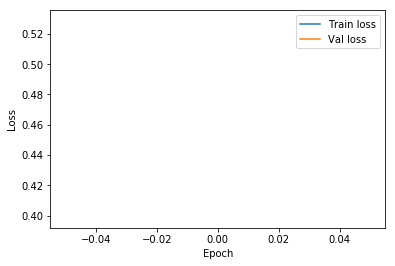

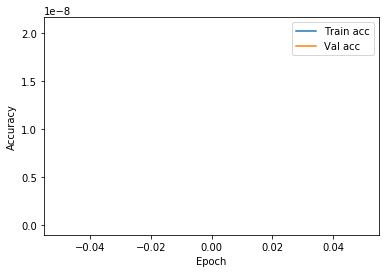

In [22]:
print(history.history.keys())

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['acc'], label = 'Train acc')
plt.plot(history.history['val_acc'], label = 'Val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Save the model
ae.save_weights('Model/AE-1_00-0607-11-36class.h5')
#ae.load_weights('Model/AE-1_00-0507-21.h5')

testEval = ae.evaluate(test_dataset,
                       steps = test_steps,
                       verbose = 1)

(100, 80)
(100, 80)
(1, 100, 80, 1)
(100, 80)
-2320.43


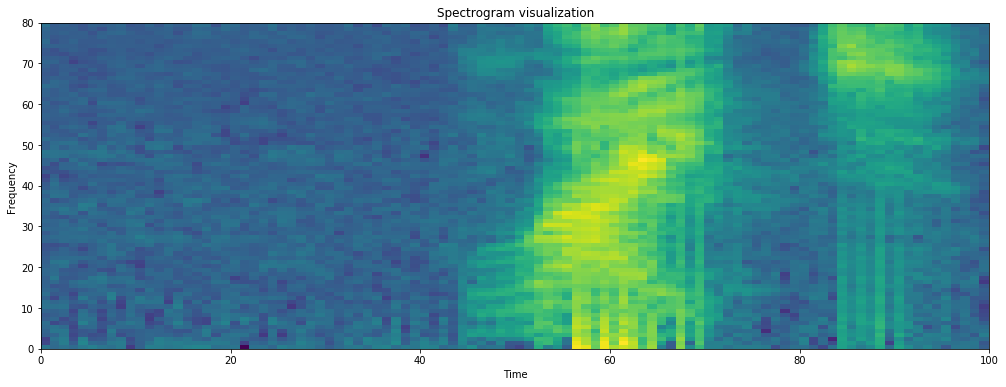

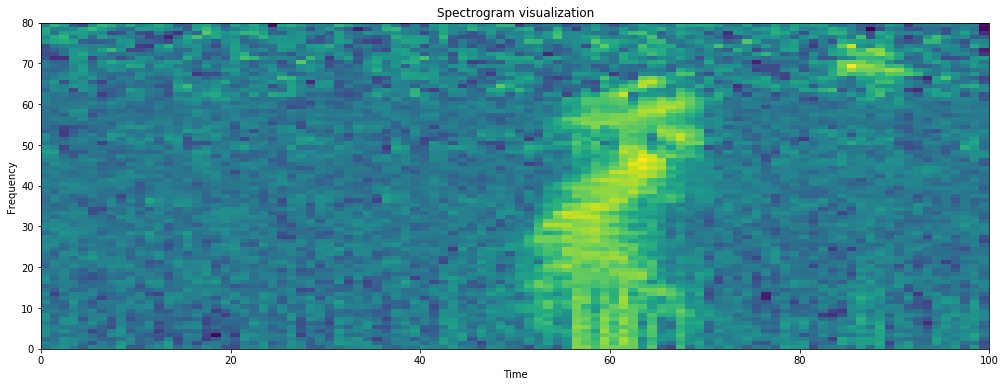

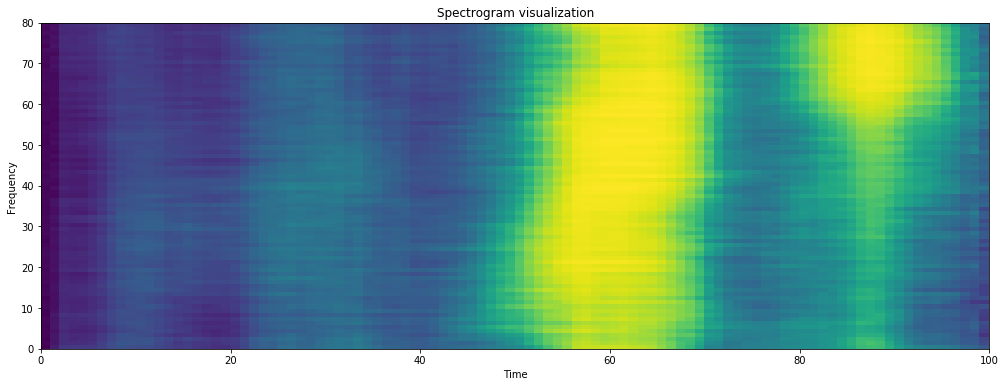

In [27]:
x = test[5]
x_clean = load_and_preprocess_data(x, dataset_dir, False)
x_noisy = load_and_preprocess_data(x, dataset_dir, True)
print(x_clean.shape)
print(x_noisy.shape)
res = ae.predict(x_noisy.reshape((1, 100, 80, 1))) 
print(res.shape)
s = res.reshape((100, 80))
print(s.shape)
print(np.sum(x_clean - s))

plt.figure(figsize=(17,6))
plt.pcolormesh(np.transpose(x_clean))

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.figure(figsize=(17,6))
plt.pcolormesh(np.transpose(x_noisy))

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.figure(figsize=(17,6))
plt.pcolormesh(np.transpose(s))

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [28]:
#Encoder = Model.Seq2SeqModel_Encoder(21, 99, 39, use_GRU = True)
classifier.summary()

weights = ae.layers[1].get_weights()
classifier.layers[1].set_weights(weights)
classifier.layers[1].trainable = False
weights = ae.layers[2].get_weights()
classifier.layers[2].set_weights(weights)
classifier.layers[2].trainable = False
weights = ae.layers[3].get_weights()
classifier.layers[3].set_weights(weights)
classifier.layers[3].trainable = False
weights = ae.layers[4].get_weights()
classifier.layers[4].set_weights(weights)
classifier.layers[4].trainable = False
weights = ae.layers[6].get_weights()
classifier.layers[6].set_weights(weights)
classifier.layers[6].trainable = False
weights = ae.layers[8].get_weights()
classifier.layers[7].set_weights(weights)
classifier.layers[7].trainable = False
weights = ae.layers[9].get_weights()
classifier.layers[8].set_weights(weights)
classifier.layers[8].trainable = False

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 5)   30          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 80, 5)   20          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 80, 1)   26          batch_normalization[0][0]        
____________________________________________________________________________________________

In [29]:
# new dataset for the classifier 
def create_dataset2(data_dir, file_names, labels, batch_size = 32, shuffle = True, cache_file = None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.numpy_function (load_and_preprocess_data, [file_name, data_dir, False], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls = os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely (capire bene anche questo repeat come funziona)
    dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))
    
    # Batch
    dataset = dataset.batch(batch_size = batch_size)
    
    # Prefetch (1 means that prefetch a batch at time)
    dataset = dataset.prefetch(buffer_size = 1)
    
    return dataset

In [30]:
batch_size2 = 128

train_dataset2 = create_dataset2(dataset_dir, train, trainLabels, batch_size = batch_size2, shuffle = True, cache_file = 'train_cache')

val_dataset2 = create_dataset2(dataset_dir, val, valLabels, batch_size = batch_size2, shuffle = False, cache_file = 'val_cache')

test_dataset2 = create_dataset2(dataset_dir, test, testWAVlabels, batch_size = batch_size2, shuffle = False, cache_file = 'test_cache')

train_steps2 = int(np.ceil(len(train) / batch_size2))
val_steps2 = int(np.ceil(len(val) / batch_size2))
test_steps2 = int(np.ceil(len(test) / batch_size2))

print("steps to completa a train epoch: " + str(train_steps2))
print("steps to completa a validation spoch: " + str(val_steps2))
print("steps to completa a test epoch: " + str(test_steps2))

steps to completa a train epoch: 663
steps to completa a validation spoch: 78
steps to completa a test epoch: 86


In [31]:
earlystopper2 = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer2 = ModelCheckpoint('Model/AE_36class_0607_11.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [32]:
learning_rate2 = 0.001
global_step2 = tf.Variable(train_steps2 * 2, trainable = False)

decayed_lr2 = tf.train.exponential_decay(learning_rate2,
                                        global_step2, train_steps2 * 2,
                                        0.4, staircase = True)

adam2 = tf.train.AdamOptimizer(learning_rate2, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

classifier.compile(optimizer = 'adam',
                   loss = tf.keras.losses.sparse_categorical_crossentropy,
                   metrics = ['sparse_categorical_accuracy', 'accuracy'])

In [33]:
num_epochs2 = 3
history = classifier.fit(train_dataset2, 
                         epochs = num_epochs2,   
                         steps_per_epoch = train_steps2,
                         validation_data = val_dataset2, 
                         validation_steps = val_steps2,
                         callbacks = [checkpointer2, earlystopper2])

Epoch 1/3
662/663 [============================>.] - ETA: 1s - loss: 3.4759 - sparse_categorical_accuracy: 0.0517 - acc: 0.0517
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.05519, saving model to Model/AE_36class_0607_11.h5
663/663 [==============================] - 857s 1s/step - loss: 3.4758 - sparse_categorical_accuracy: 0.0517 - acc: 0.0517 - val_loss: 3.4609 - val_sparse_categorical_accuracy: 0.0552 - val_acc: 0.0552
Epoch 2/3
662/663 [============================>.] - ETA: 0s - loss: 3.4176 - sparse_categorical_accuracy: 0.0671 - acc: 0.0671
Epoch 00002: val_sparse_categorical_accuracy improved from 0.05519 to 0.06611, saving model to Model/AE_36class_0607_11.h5
663/663 [==============================] - 346s 522ms/step - loss: 3.4177 - sparse_categorical_accuracy: 0.0671 - acc: 0.0671 - val_loss: 3.4156 - val_sparse_categorical_accuracy: 0.0661 - val_acc: 0.0661
Epoch 3/3
662/663 [============================>.] - ETA: 0s - loss: 3.3845 - sparse_categoric

In [35]:
x = test[11]
l = testWAVlabels[11]
x_clean = load_and_preprocess_data(x, dataset_dir, False)
x_noisy = load_and_preprocess_data(x, dataset_dir, True)
res_c = classifier.predict(x_clean.reshape((1, 100, 80, 1))) 
res_n = classifier.predict(x_noisy.reshape((1, 100, 80, 1))) 
print("Predict Noisy: " + str(res_n.argmax()))
print("Predict Clean: " + str(res_c.argmax()))
print("Correct: " + str(l))

Predict Noisy: 9
Predict Clean: 7
Correct: 7
